## Analysis of publications related to OpenNeuro

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as tkr
datadir = '../data/openneuro'
figdir = '../figures'

plt.rc('font', family='Helvetica')

In [2]:
metadata = pd.read_csv(os.path.join(datadir, 'metadata_06182021.csv'), skiprows=1)
rename_dict = {'Assession Number': 'AccessionNumber',
              'Dataset made public (MM/DD/YYYY)': 'ReleaseDate',
              '# of subjects': 'NSubjects',
              'Species?': 'Species',
              'Modalities available?': 'Modalities'}
metadata = metadata.rename(rename_dict, axis=1)

In [3]:
metadata.columns

Index(['AccessionNumber', 'Dataset URL', 'Dataset name', 'ReleaseDate',
       'Most recent snapshot date (MM/DD/YYYY)', 'NSubjects', 'Modalities',
       'DX status(es)', 'Ages (range)', 'Tasks completed?',
       '# of trials (if applicable)', 'Study design', 'Domain studied',
       'Longitudinal?', 'Processed data?', 'Species',
       'DOI of paper associated with DS (from submitter lab)',
       'DOI of paper because DS on OpenNeuro',
       'Senior Author (lab that collected data) Last, First'],
      dtype='object')

In [4]:
metadata['ReleaseDate'] = pd.to_datetime(metadata['ReleaseDate'])

# Collapse any dates prior to 07/17/2018 when OpenfMRI datasets were uploaded
metadata.loc[metadata["ReleaseDate"] < "2018-07-17", "ReleaseDate"] = "2018-07-17"

## Statistics on the database

In [5]:
print('Number of datasets:', len(metadata['Dataset name'].unique()))
print('Number of datasets:', len(metadata['AccessionNumber'].unique()))


Number of datasets: 546
Number of datasets: 548


In [6]:
print('Number of subjets:', metadata['NSubjects'].sum())


Number of subjets: 18758


In [7]:
data_paper_dois = metadata['DOI of paper associated with DS (from submitter lab)'].unique()
print(f'Number of data paper DOIs: {data_paper_dois.shape[0]}')
print(f'Proportion of data paper DOIs: {data_paper_dois.shape[0]/metadata.shape[0]}')

Number of data paper DOIs: 376
Proportion of data paper DOIs: 0.6861313868613139


In [8]:
user_paper_dois = metadata['DOI of paper because DS on OpenNeuro'].unique()
print(f'Number of user paper DOIs: {user_paper_dois.shape[0]}')

Number of user paper DOIs: 29


Clean up data to create plots

In [9]:
df_sorted = metadata.sort_values('ReleaseDate')
df_sorted['ones'] = 1
df_sorted['cumulative'] = df_sorted['ones'].cumsum()
df_sorted['cumulative_subjects'] = df_sorted['NSubjects'].cumsum()
dates = df_sorted['ReleaseDate'].unique()
print('Earliest dataset:', dates.min())
print('Latest dataset:', dates.max())

# fix dates to reflect fact that early datasets were all from openneuro
#df_sorted.loc[df_sorted['ReleaseDate'] < pd.Timestamp(2018,8,1), 'ReleaseDate'] = '2018-08-01'
df_sorted

Earliest dataset: 2018-07-17T00:00:00.000000000
Latest dataset: 2021-06-15T00:00:00.000000000


,AccessionNumber,Dataset URL,Dataset name,ReleaseDate,Most recent snapshot date (MM/DD/YYYY),NSubjects,Modalities,DX status(es),Ages (range),Tasks completed?,...,Domain studied,Longitudinal?,Processed data?,Species,DOI of paper associated with DS (from submitter lab),DOI of paper because DS on OpenNeuro,"Senior Author (lab that collected data) Last, First",ones,cumulative,cumulative_subjects
0,ds000001,https://openneuro.org/datasets/ds000001/versio...,Balloon Analog Risk-taking Task,2018-07-17,7/13/2018,16,"MRI - anat, MRI - func",Healthy/Control,"18-25, 26-34",Ballon Analog Risk Task,...,"Risk-taking, Decision-making",No,No,Human,10.3389/fnins.2012.00080,NaN,"Poldrack, Russ",1,1,16
89,ds000256,https://openneuro.org/datasets/ds000256/versio...,Behavioral interventions for reducing head mot...,2018-07-17,7/16/2018,24,"MRI - anat, MRI - func, FieldMap",Healthy/Control,"0-10, 11-17","restbaseline, restfixationadaptive, restfixati...",...,reducing head motion in children,No,Yes,Human,10.1016/j.neuroimage.2018.01.023,NaN,"Dosenbach, Nico",1,2,40
88,ds000255,https://openneuro.org/datasets/ds000255/versio...,Visual image reconstruction,2018-07-17,7/16/2018,2,"MRI - anat, MRI - func",Healthy/Control,NaN,"viewFigure, viewRandom",...,visual image reconstruction,Yes,No,Human,10.1016/j.neuron.2008.11.004,NaN,"Kamitani, Yukiyasu",1,3,42
87,ds000254,https://openneuro.org/datasets/ds000254/versio...,ds000254_R1.0.0,2018-07-17,7/17/2018,13,"MRI - anat, MRI - func",Healthy/Control,"18-25, 26-34, 35-50",bilateral finger tapping,...,novel sequence,No,No,Human,10.1371/journal.pone.0169253,NaN,"Cohen, Alexander",1,4,55
86,ds000253,https://openneuro.org/datasets/ds000253/versio...,Female action video game players.,2018-07-17,7/17/2018,20,"MRI - anat, MRI - func",Healthy/Control,"18-25, 26-34, 35-50",visuomotor task,...,"visuospatial, attention-related skills",No,Yes,Human,10.1371/journal.pone.0189110,NaN,"Sergio, Lauren",1,5,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,ds003419,https://openneuro.org/datasets/ds003419/versio...,MRI Lab Graz: Two weeks Running Reduces Depres...,2021-06-09,12/4/2020,58,MRI - anat,NaN,"18-25, 26-34",NaN,...,NaN,Yes,Yes,Human,NaN,NaN,"Papousek, Ilona",1,544,18513
546,ds003690,https://openneuro.org/datasets/ds003690/versio...,"EEG, ECG and pupil data from young and older a...",2021-06-10,6/10/2021,75,EEG,Healthy/Control,"18-25, 26-34, 35-50, 51-65, 66+","gonogo, passive, simpleRT",...,NaN,No,No,Human,"10.1016/j.neurobiolaging.2018.09.028, 10.1016/...",NaN,"Castelo-Branco, Miguel",1,545,18588
544,ds003685,https://openneuro.org/datasets/ds003685/versio...,A test-retest resting and cognitive state EEG ...,2021-06-11,6/11/2021,60,EEG,Healthy/Control,"18-25, 26-34","memory, mathematic, eyes open, music, eyes closed",...,Neuroscience,No,No,Human,10.1016/j.jneumeth.2020.108985,NaN,"Lei, Xu",1,546,18648
545,ds003688,https://openneuro.org/datasets/ds003688/versio...,Open multimodal iEEG-fMRI dataset from natural...,2021-06-13,6/12/2021,63,"MRI - anat, MRI - func, iEEG",medication-resistant epilepsy,"0-10, 11-17, 18-25, 26-34, 35-50, 51-65","film, rest",...,"Language, speech, auditory and visual perception",No,No,Human,10.1101/2021.06.09.447733,NaN,"Ramsey, Nick",1,547,18711


In [10]:
from collections import defaultdict

datasets = defaultdict(lambda: 0)
subjects = defaultdict(lambda: 0)

for date, nsub in metadata[["ReleaseDate", "NSubjects"]].values:
    datasets[date.strftime('%Y-%m-%d')] += 1
    subjects[date.strftime('%Y-%m-%d')] += nsub

datadict = defaultdict(list)
for k in datasets.keys():
    datadict["ReleaseDate"].append(k)
    datadict["n_datasets"].append(datasets[k])
    datadict["n_subjects"].append(subjects[k])
    
df_plotting = pd.DataFrame(datadict)
df_plotting['ReleaseDate'] = pd.to_datetime(df_plotting['ReleaseDate'])
df_plotting = df_plotting.set_index("ReleaseDate").sort_values(by="ReleaseDate")

df_plotting["cumsum_datasets"] = df_plotting['n_datasets'].cumsum()
df_plotting['cumsum_subjects'] = df_plotting['n_subjects'].cumsum()

release_dates = df_plotting.index.astype(int)

df_plotting

/tmp/ipykernel_3578110/4091817837.py:23: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  release_dates = df_plotting.index.astype(int)


,n_datasets,n_subjects,cumsum_datasets,cumsum_subjects
ReleaseDate,,,,
2018-07-17,115,3899,115,3899
2018-07-18,12,278,127,4177
2018-07-19,1,1,128,4178
2018-07-24,1,1,129,4179
2018-07-26,1,18,130,4197
...,...,...,...,...
2021-06-09,1,58,544,18513
2021-06-10,1,75,545,18588
2021-06-11,1,60,546,18648


In [11]:
midyears = pd.to_datetime([f"20{yr}-07-02" for yr in range(18, 22)]).astype(int)  # July 2 is the midpoint of year

/tmp/ipykernel_3578110/336077133.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  midyears = pd.to_datetime([f"20{yr}-07-02" for yr in range(18, 22)]).astype(int)  # July 2 is the midpoint of year


Plot # of datasets over time

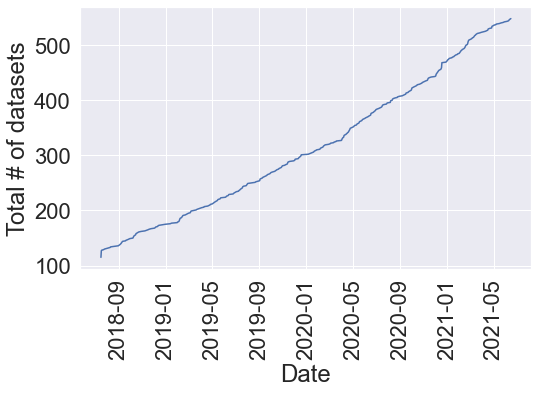

In [12]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)  # crazy big
sns.lineplot(x='ReleaseDate', y='cumsum_datasets', data=df_plotting)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total # of datasets')
plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'n_datasets.pdf'))

Plot # of subjects over time

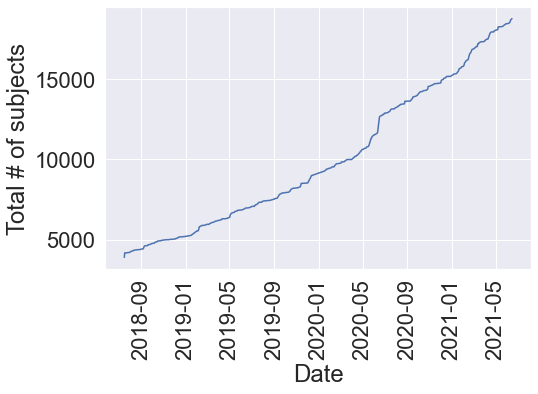

In [13]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)  # crazy big
sns.lineplot(x='ReleaseDate', y='cumsum_subjects', data=df_plotting)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total # of subjects')
plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'n_subjects.pdf'))

Plot both together

/tmp/ipykernel_3578110/1675757724.py:109: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  years = pd.to_datetime(["2018-01-05", "2018-12-26",


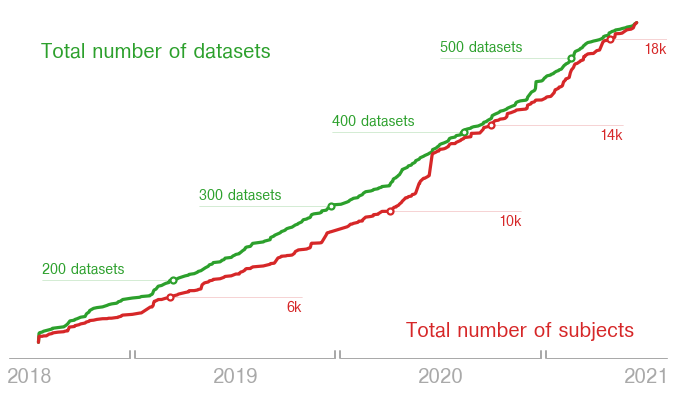

In [14]:
# Edit general skin
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Datasets
color = 'tab:green'
ax1.set_xlabel('Date', fontsize=20, fontname="Helvetica")
ax1 = sns.lineplot(x=release_dates, y=df_plotting['cumsum_datasets'], 
                   color=color, label='Datasets', linewidth=3.2)
# Plot Subjects
ax2 = ax1.twinx()
color = 'tab:red'
ax2 = sns.lineplot(x=release_dates, y=df_plotting['cumsum_subjects'],
                   color=color, label='Subjects', linewidth=3.2)
# Grid & spines
ax1.grid(False)
ax2.grid(False)
ax1.spines.left.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(False)
ax2.spines.bottom.set_visible(False)
# ax1.spines.bottom.set_position(('outward', 10))

# Manipulate axes
ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax1.get_legend().remove()
ax2.get_legend().remove()

# Place year label at the middle of each year
ax1.set_xticks(midyears)
ax1.set_xticklabels([f"20{yr}" for yr in range(18, 22)], fontname="Helvetica", fontsize=20, color="darkgray")

# Annotate total datasets
x_lim = ax1.get_xlim()
y1_lim = ax1.get_ylim()
normalized_dates = (release_dates - x_lim[0]) / (x_lim[1] - x_lim[0])
num_ds = [200, 300, 400, 500]
x_dates_norm = np.interp(num_ds, df_plotting['cumsum_datasets'], normalized_dates)
x_dates = np.interp(num_ds, df_plotting["cumsum_datasets"], release_dates)
y1_norm = (np.array(num_ds) - y1_lim[0]) / (y1_lim[1] - y1_lim[0])

for y, x, y_norm in zip(num_ds, x_dates_norm, y1_norm):
    xorig = max(x - 0.2, 0)
    ax1.axhline(y=y, xmax=x, xmin=xorig, color='tab:green', alpha=0.4, linewidth=0.5)
    ax1.text(xorig, y_norm + 0.01, f"{y} datasets",
             transform=ax1.transAxes,
             verticalalignment='bottom', horizontalalignment='left',
             color='tab:green', fontname="Helvetica", fontsize=14)

ax1.plot(
    x_dates,
    num_ds,
    marker="o",
    markeredgecolor="tab:green",
    markerfacecolor="white",
    color="white",
    ms=6,
    markeredgewidth=2.2,
    fillstyle="full",
    linestyle="None",
)
    
# Annotate total subjects
num_subj = [6000, 10000, 14000, 18000]
x_subj_dates = np.interp(num_subj, df_plotting['cumsum_subjects'], normalized_dates)
x2_dates = np.interp(num_subj, df_plotting["cumsum_subjects"], release_dates)
y2_lim = ax2.get_ylim()
y2_norm = (np.array(num_subj) - y2_lim[0]) / (y2_lim[1] - y2_lim[0])
for y, x, y_norm in zip(num_subj, x_subj_dates, y2_norm):
    xend = min(x + 0.2, 1.0)
    ax2.axhline(y=y, xmin=x, xmax=xend, color='tab:red', alpha=0.4, linewidth=0.5)
    ax2.text(xend, y_norm - 0.01, f"{y // 1000}k",
             transform=ax2.transAxes,
             verticalalignment='top', horizontalalignment='right',
             color='tab:red', fontname="Helvetica", fontsize=14)
    
ax2.plot(
    np.interp(num_subj, df_plotting["cumsum_subjects"], release_dates),
    num_subj,
    marker="o",
    markeredgecolor="tab:red",
    markerfacecolor="white",
    color="white",
    ms=6,
    markeredgewidth=2.2,
    fillstyle="full",
    linestyle="None",
)

# Add Y-axis labels in the middle of the plot, linked by color
ax2.text(0.05, 0.9, 'Total number of datasets',
         verticalalignment='top', horizontalalignment='left',
         transform=ax2.transAxes,
         color='tab:green', fontname="Helvetica", fontsize=20)

ax2.text(0.95, 0.05, 'Total number of subjects',
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax2.transAxes,
         color='tab:red', fontname="Helvetica", fontsize=20)

# Replace X-axis with a fancier timeline plot
years = pd.to_datetime(["2018-01-05", "2018-12-26",
                    "2019-01-05", "2019-12-26",
                    "2020-01-05", "2020-12-26",
                    "2021-01-05", "2021-12-26",]).astype(int).values
years_norm = (years - x_lim[0]) / (x_lim[1] - x_lim[0])
years_norm[0] = 0.0
years_norm[-1] = 1.0

for yr_start, yr_end in years_norm.reshape(-1, 2):
    ax1.axhline(
        y1_lim[0],
        xmin=yr_start,
        xmax=yr_end,
        clip_on=False,
        color="darkgray",
        linewidth=1,
    )

for yr in years[1:-1]:
    ax1.axvline(
        yr,
        ymin=0,
        ymax=0.02,
        clip_on=False,
        color="darkgray",
        linewidth=2,
    )        
        
ax1.set_yticks([])
ax2.set_yticks([])
        
plt.tight_layout()
plt.savefig('combined_growth.png')
plt.savefig('combined_growth.pdf')

## analysis of data types: species

In [15]:
# clean up labels
cleanup_dict = {'Mice': 'Mouse',
               'Rats': 'Rat',
                'rat': 'Rat',
                'Adult Wistar rats': 'Rat',
               'C57bl/6 mixed gender mice': 'Mouse',
               'mouse': 'Mouse',
               'Macaque': 'NHP',
               'mouse lemur': 'NHP'}

species_counts_clean = {'Mouse': 0,
                        'Rat': 0,
                       'Human': 0,
                       'Phantom': 0,
                       'NHP': 0}

for idx in df_sorted.index:
    if df_sorted.loc[idx,'Species'] in cleanup_dict:
        df_sorted.loc[idx, 'Species'] = cleanup_dict[df_sorted.loc[idx,'Species']]

species_counts = df_sorted['Species'].value_counts()
for i in range(species_counts.loc['Mice and Rats']):
    species_counts.loc['Mouse'] = species_counts.loc['Mouse'] + 1
    species_counts.loc['Rat'] = species_counts.loc['Rat'] + 1
species_counts.drop('Mice and Rats', inplace=True)
print('Total # of datasets:', species_counts.sum())
species_counts

Total # of datasets: 543


Human            517
Mouse             17
Rat                5
NHP                2
phantoms           1
Juvenile pigs      1
Name: Species, dtype: int64

In [16]:
species_counts/species_counts.sum()

Human            0.952118
Mouse            0.031308
Rat              0.009208
NHP              0.003683
phantoms         0.001842
Juvenile pigs    0.001842
Name: Species, dtype: float64

## analysis of data types: modality

In [17]:

modalities = df_sorted['Modalities'].dropna()

mod_list = defaultdict(lambda: 0)

for i in modalities:
    for k in i.split(','):
        k = k.lstrip().lower()
        mod_list[k] = mod_list[k] + 1

In [18]:
mod_df = pd.Series(mod_list)
mod_df.sort_values(ascending=False)

mri - anat     465
mri - func     413
field map       71
eeg             63
mri - dwi       52
fieldmap        35
meg             21
beh             11
pet              8
ieeg             8
asl              3
fmap             2
ute              1
dixon            1
field map        1
calibration      1
fieldmaps        1
swi              1
eyetrack         1
stat             1
angiography      1
venograms        1
angiograms       1
motion           1
dtype: int64

## Analysis of dataset size

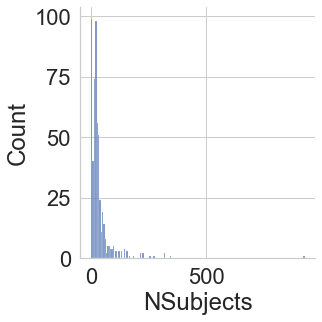

In [19]:
# number of subjects
import numpy as np
df_sorted['nsubs'] = df_sorted['NSubjects']
nsubs = df_sorted.query('nsubs > 0')['NSubjects']
sns.displot(nsubs) #, log_scale=True)

In [20]:
print('median # of subjects:', nsubs.median())


median # of subjects: 22.0


In [21]:
print('# of datasets with more than 100 subjects', (nsubs > 100).sum())

# of datasets with more than 100 subjects 28


In [22]:
print('maximum dataset size:', nsubs.max())

maximum dataset size: 928


## Analysis of sessions

Using data obtained from datalad datasets

In [23]:
datalad_metadata = pd.read_csv('../data/openneuro/ds_info.csv')
datalad_metadata.head()

,Unnamed: 0,dsnum,ntasks,nsessions,nsubs,tasknames
0,0,ds000001,1,1,16,{'balloon analog risk task'}
1,1,ds000002,3,1,17,"{'probabilistic classification', 'mixed event-..."
2,2,ds000003,1,1,13,{'rhyme judgment'}
3,3,ds000005,1,1,16,{'mixed-gambles task'}
4,4,ds000006,1,2,14,{'living-nonliving decision with plain or mirr...


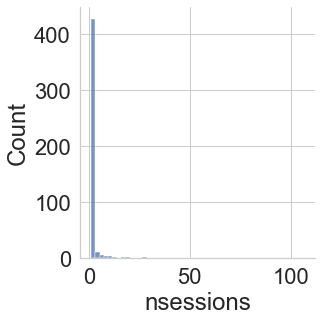

In [24]:
sns.displot(datalad_metadata.nsessions, bins=50)

In [25]:
print('max # of sessions:', datalad_metadata.nsessions.max())
print('# of datasets with more than 1 session:', (datalad_metadata.nsessions > 1).sum())


max # of sessions: 107
# of datasets with more than 1 session: 121


In [26]:
# further analysis of tasks is done in task_analysis.ipynb
print('max # of tasks:', datalad_metadata.ntasks.max())
print('# of datasets with more than 1 task:', (datalad_metadata.ntasks > 1).sum())


max # of tasks: 48
# of datasets with more than 1 task: 189


## Analysis of publications

In [27]:
print('Proportion of papers with a DOI:',
      df_sorted['DOI of paper associated with DS (from submitter lab)'].dropna().shape[0]/df_sorted.shape[0])

Proportion of papers with a DOI: 0.7226277372262774


In [28]:
dois = []
multi_doi = 0
for i in df_sorted['DOI of paper associated with DS (from submitter lab)'].dropna():
    i_s = i.split(',')
    if len(i_s) > 1:
        multi_doi += 1
    dois = dois + i_s
    
print('# of papers associated with more than one DOI:', multi_doi)
print('# of unique DOIs:', len(set(dois)))

# of papers associated with more than one DOI: 66
# of unique DOIs: 570


## figure showing width/breadth/depth

In [29]:
datalad_metadata.shape

(469, 6)

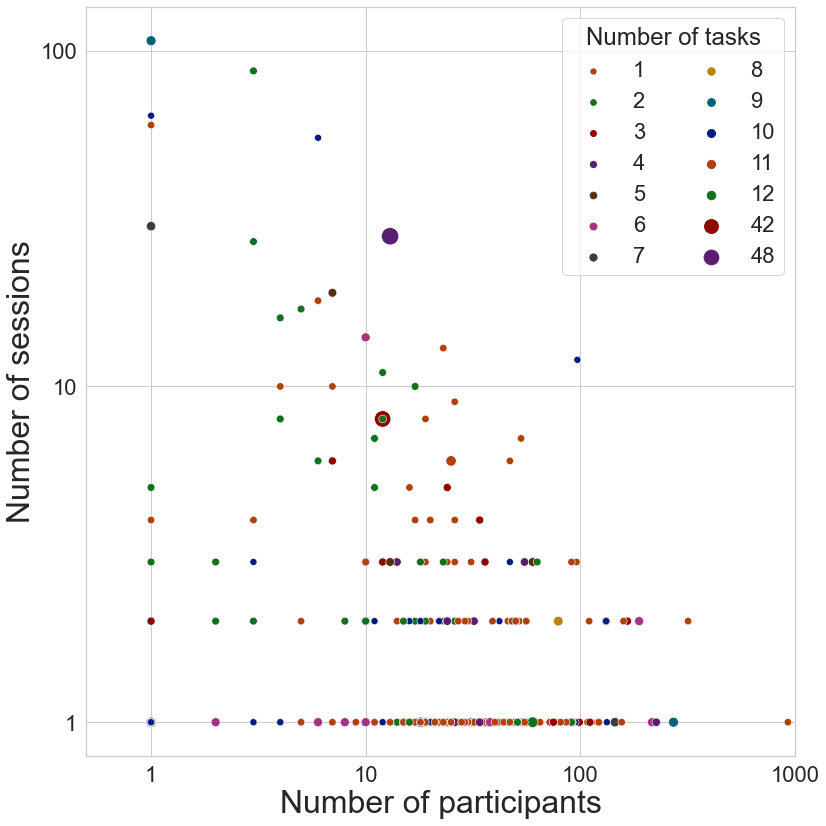

In [30]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 12))
splot = sns.scatterplot(x='nsubs', y='nsessions', size='ntasks', hue='ntasks',
                         data=datalad_metadata,
                        sizes=(50, 300), palette="dark",
                        legend = 'brief')

splot.set(xscale="log")
splot.set(yscale="log")
plt.xlim([.5, 1000])
plt.xlabel('Number of participants', fontsize=32)
plt.ylabel('Number of sessions', fontsize=32)

leg = splot.axes.get_legend()
new_title = '# of tasks'
leg.set_title(new_title)

for axis in [splot.xaxis, splot.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)

handles, labels = splot.get_legend_handles_labels()
for i, h in enumerate(handles[1:15]):
    h.set_sizes([24 + int(labels[i+1])*4])
splot.legend(handles=handles[1:15], labels=labels[1:15], loc=1, 
            ncol=2, bbox_to_anchor=(1,1), title='Number of tasks')
plt.tight_layout()
# plt.savefig('../figures/dataset_size.png')


In [31]:
dir(handles[0])

['_A',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_checker',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiaseds',
 '_axes',
 '_bcast_lwls',
 '_callbacks',
 '_capstyle',
 '_check_update',
 '_clipon',
 '_clippath',
 '_contains',
 '_default_contains',
 '_edge_default',
 '_edge_is_mapped',
 '_edgecolors',
 '_face_is_mapped',
 '_facecolors',
 '_factor',
 '_get_clipping_extent_bbox',
 '_get_default_antialiased',
 '_get_default_edgecolor',
 '_get_default_facecolor',
 '_get_default_linewidth',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_in_layout',
 '_joinstyle',
 '_label',
 '_linestyles',
 '_linewidths',
 '_mapped_colors',
 '_mouseo

In [32]:
labels

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '42',
 '48',
 '0',
 '8',
 '16',
 '24',
 '32',
 '40',
 '48']